# Conclusions
to improve results the following experiments shouled be run and tracked:
* find more variabes that describe customers 
* check various sampling strategies
* determine what level of precision and recall are acceptable
* check what should be optimized: maximize number of correct decisions, max profit, any other business metric? 
interesting doc on threshold selection: [http://research.google.com/bigpicture/attacking-discrimination-in-ml/] 

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import pickle

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTENC, RandomOverSampler

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve

pd.options.display.max_rows = 40
pd.options.display.max_columns = 999999
seed = 12345

In [2]:
import os
os.chdir("..")

In [3]:
from src.data.udfs_data_prep import compute_counts_and_share, convert_object_cols_to_category
from src.models.udfs_modelling import get_summary, reclassify_by_treshold, compute_f1, summarise_metrices, get_confusion_matrix, format_confusion_matrix
from src.models.udfs_modelling import get_rf_feature_imp, extract_and_plot_hyperopt_trials, save_intermin_data_and_model

# Data load

In [4]:
df_merged = pd.read_pickle('data/processed/df_application_record_classified_post_feature_eng.pickle')

In [5]:
df_merged.head()

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_housing_type,occupation_type,cnt_fam_members,amt_income_per_person,age,job_tenure,flag_employed,single_adult,target
id,,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,Working,Higher education,Rented apartment,Unknown,2,213750.0,32.890411,12.443836,1,0,0
5008805,1,1,1,0,427500.0,Working,Higher education,Rented apartment,Unknown,2,213750.0,32.890411,12.443836,1,0,0
5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,House / apartment,Security staff,2,56250.0,58.832877,3.106849,1,0,0
5008810,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,Sales staff,1,270000.0,52.356164,8.358904,1,1,0
5008811,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,Sales staff,1,270000.0,52.356164,8.358904,1,1,0


In [6]:
df_merged.shape

(19996, 16)

In [7]:
df_merged.isnull().sum()

code_gender              0
flag_own_car             0
flag_own_realty          0
cnt_children             0
amt_income_total         0
name_income_type         0
name_education_type      0
name_housing_type        0
occupation_type          0
cnt_fam_members          0
amt_income_per_person    0
age                      0
job_tenure               0
flag_employed            0
single_adult             0
target                   0
dtype: int64

compute_counts_and_share# Train test spli

In [8]:
compute_counts_and_share(df_merged, 'target')

,count,share
0,19687,0.984547
1,309,0.015453


# Data preprocessing

In [9]:
y = df_merged['target']
X = df_merged.drop('target', axis = 1)

In [10]:
X.loc[:, X.select_dtypes("object_").columns]

,name_income_type,name_education_type,name_housing_type,occupation_type
id,,,,
5008804,Working,Higher education,Rented apartment,Unknown
5008805,Working,Higher education,Rented apartment,Unknown
5008806,Working,Secondary / secondary special,House / apartment,Security staff
5008810,Commercial associate,Secondary / secondary special,House / apartment,Sales staff
5008811,Commercial associate,Secondary / secondary special,House / apartment,Sales staff
...,...,...,...,...
5149729,Working,Secondary / secondary special,House / apartment,Unknown
5149775,Working,Secondary / secondary special,House / apartment,Laborers
5149834,Commercial associate,Higher education,House / apartment,Medicine staff


## PCA 

In [11]:
X_pca = X.copy()
cat_features = X.select_dtypes("object_").columns

lbl_encode = LabelEncoder()
for i in cat_features:
    X_pca[i] = X_pca[[i]].apply(lbl_encode.fit_transform)
X_pca.loc[:, cat_features].head()
X_pca.head()

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_housing_type,occupation_type,cnt_fam_members,amt_income_per_person,age,job_tenure,flag_employed,single_adult
id,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,4,1,4,17,2,213750.0,32.890411,12.443836,1,0
5008805,1,1,1,0,427500.0,4,1,4,17,2,213750.0,32.890411,12.443836,1,0
5008806,1,1,1,0,112500.0,4,4,1,16,2,56250.0,58.832877,3.106849,1,0
5008810,0,0,1,0,270000.0,0,4,1,14,1,270000.0,52.356164,8.358904,1,1
5008811,0,0,1,0,270000.0,0,4,1,14,1,270000.0,52.356164,8.358904,1,1


In [12]:
scaler_pca = StandardScaler()
cols_to_scale_pca = ['cnt_children', 'amt_income_total', 'cnt_fam_members',
                 'amt_income_per_person', 'age', 'job_tenure']
scaler = scaler_pca.fit(X_pca.loc[:,cols_to_scale_pca])

X_pca.loc[:,cols_to_scale_pca] = scaler.transform(X_pca.loc[:,cols_to_scale_pca])

In [13]:
pca = PCA()
X_components = pca.fit_transform(X_pca)
X_components = X_components[:, 0:3]

# # Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_components.shape[1])]
component_names
X_components = pd.DataFrame(X_components, columns=component_names)
X_components
X = pd.concat([X, X_components.set_index(X.index)], axis=1)

## Data split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state = 123)

## Scaling

In [15]:
X_train.describe()

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,cnt_fam_members,amt_income_per_person,age,job_tenure,flag_employed,single_adult,PC1,PC2,PC3
count,15996.000000,15996.000000,15996.000000,15996.000000,1.599600e+04,15996.00000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000
mean,0.335021,0.388097,0.659227,0.432796,1.876312e+05,2.21049,99992.469870,44.137656,6.196185,0.837709,0.222993,0.001580,0.007490,0.000492
std,0.472013,0.487332,0.473984,0.736354,1.017679e+05,0.90327,71653.033018,11.292522,6.848725,0.368729,0.416267,5.652600,1.764610,1.495467
min,0.000000,0.000000,0.000000,0.000000,2.700000e+04,1.00000,9000.000000,21.252055,-1.000000,0.000000,0.000000,-7.687200,-6.307790,-7.522878
25%,0.000000,0.000000,0.000000,0.000000,1.215000e+05,2.00000,56250.000000,34.602740,1.200000,1.000000,0.000000,-6.314600,-1.401220,-1.003496
50%,0.000000,0.000000,1.000000,0.000000,1.575000e+05,2.00000,78750.000000,43.139726,4.597260,1.000000,0.000000,0.544931,0.288792,-0.102796
75%,1.000000,1.000000,1.000000,1.000000,2.250000e+05,3.00000,123750.000000,53.375342,8.934932,1.000000,0.000000,4.564596,1.520291,0.785698
max,1.000000,1.000000,1.000000,14.000000,1.575000e+06,15.00000,900000.000000,68.909589,42.906849,1.000000,1.000000,10.831413,7.733730,16.786272


In [16]:
scaler = StandardScaler()
cols_to_scale = [ 'cnt_children', 'amt_income_total', 'cnt_fam_members',
                 'amt_income_per_person', 'age', 'job_tenure',
                 'PC1', 'PC2', 'PC3']
scaler = scaler.fit(X_train.loc[:,cols_to_scale])

X_train.loc[:,cols_to_scale] = scaler.transform(X_train.loc[:,cols_to_scale])
X_test.loc[:,cols_to_scale] = scaler.transform(X_test.loc[:,cols_to_scale])

## Sampling

In [17]:
compute_counts_and_share(pd.DataFrame({'target': y_train}), 'target')

,count,share
0,15749,0.984559
1,247,0.015441


In [18]:
undersample = RandomUnderSampler(sampling_strategy = 0.1)
X_train_balanced, y_train_balanced = undersample.fit_resample(X_train, y_train)

In [19]:
compute_counts_and_share(pd.DataFrame({'target': y_train_balanced}), 'target')

,count,share
0,2470,0.909091
1,247,0.090909


In [20]:
# oversample = SMOTENC(random_state=seed,
#                      sampling_strategy = 0.9,
#                      categorical_features=[X_train.columns.isin(['name_income_type', 'name_education_type',
#                                                                  'name_housing_type', 'occupation_type'])])

oversample = RandomOverSampler(random_state=seed,
                     sampling_strategy = 0.9)

X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_balanced, y_train_balanced)

In [21]:
compute_counts_and_share(pd.DataFrame({'target': y_train_balanced}), 'target')

,count,share
0,2470,0.526316
1,2223,0.473684


## One hot encoding

In [22]:
cat_vars = X_train_balanced.select_dtypes("object_").columns

In [23]:
enc = OneHotEncoder(handle_unknown = 'infrequent_if_exist', min_frequency = 2)
enc = enc.fit(X_train_balanced.loc[:, cat_vars])

In [24]:
X_train_balanced_one_hot = enc.transform(X_train_balanced.loc[:, cat_vars]).toarray()
X_test_one_hot = enc.transform(X_test.loc[:, cat_vars]).toarray()

In [25]:
X_train_balanced_one_hot = pd.DataFrame(X_train_balanced_one_hot,
                                        columns = enc.get_feature_names_out().tolist())
X_train_balanced_one_hot = X_train_balanced_one_hot.set_index(X_train_balanced.index)

X_test_one_hot = pd.DataFrame(X_test_one_hot,
                                        columns = enc.get_feature_names_out().tolist())
X_test_one_hot = X_test_one_hot.set_index(X_test.index)

In [26]:
# X_train_balanced_one_hot = pd.concat([X_train_balanced.drop(cat_vars, axis = 1), X_train_balanced_one_hot.set_index(X_train_balanced.index)], axis=1)
# X_test_one_hot = pd.concat([X_test.drop(cat_vars, axis = 1), X_test_one_hot.set_index(X_test.index)], axis=1)

In [27]:
X_train_balanced_one_hot = X_train_balanced.drop(cat_vars, axis = 1).join(X_train_balanced_one_hot)
X_test_one_hot = X_test.drop(cat_vars, axis = 1).join(X_test_one_hot)

## Under-sampling: Tomek links

In [28]:
undersample_tomek = TomekLinks(sampling_strategy = 'majority')
(X_train_balanced_one_hot, y_train_balanced_one_hot) = undersample_tomek.fit_resample(X_train_balanced_one_hot, y_train_balanced)

In [29]:
compute_counts_and_share(pd.DataFrame({'target': y_train_balanced_one_hot}), 'target')

,count,share
0,2470,0.526316
1,2223,0.473684


# Modelling

## Try different models with default parameters

In [30]:
classifiers = {
    "LogisticRegression" : LogisticRegression(max_iter = 300, class_weight='balanced'),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(class_weight='balanced'),
    "RandomForest" : RandomForestClassifier(class_weight='balanced'),
    "XGBoost" : XGBClassifier(scale_pos_weight=10),
    "LGBMClassifier" : lgb.LGBMClassifier(class_weight='balanced')
}

In [31]:
# from sklearn.model_selection import cross_validate
train_cv_scores = []
test_scores = []

for key, classifier in classifiers.items():
    print(key)
    if key == "LGBMClassifier":
        X_train_data = convert_object_cols_to_category(X_train_balanced)
        y_train_data = y_train_balanced
        X_test_data = convert_object_cols_to_category(X_test)
        y_test_data = y_test

        classifier.fit(X_train_data, y_train_data, categorical_feature = ['name_income_type', 'name_education_type', 'name_housing_type', 'occupation_type'])
    else:
        X_train_data = X_train_balanced_one_hot
        y_train_data = y_train_balanced_one_hot
        X_test_data = X_test_one_hot
        y_test_data = y_test
        
        classifier.fit(X_train_data, y_train_data)
        
    train_cv_score = cross_val_score(classifier, X_train_data, y_train_data, scoring="average_precision", cv = 5).mean()
    train_cv_scores.append(train_cv_score)
    test_predictions = classifier.predict(X_test_data)
    test_score = average_precision_score(y_test_data, test_predictions)
    test_scores.append(test_score)  

LogisticRegression
KNeighbors
DecisionTree
RandomForest
XGBoost
LGBMClassifier


C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.


In [32]:
print(train_cv_scores)
print(test_scores)

[0.6332314434405883, 0.9071499990229857, 0.8978751937718755, 0.9880571461240709, 0.9857269560128126, 0.9851709625382055]
[0.01580695564516129, 0.029795989537925022, 0.05550803453651517, 0.09319659982563208, 0.04900601421541826, 0.06406679700228088]


In [33]:
models_comparison = pd.DataFrame({'model': classifiers.keys(), 'train_mean_score': train_cv_scores, 'test_score': test_scores})
models_comparison

,model,train_mean_score,test_score
0,LogisticRegression,0.633231,0.015807
1,KNeighbors,0.907150,0.029796
2,DecisionTree,0.897875,0.055508
3,RandomForest,0.988057,0.093197
4,XGBoost,0.985727,0.049006
5,LGBMClassifier,0.985171,0.064067


## Hyperparameter tuning for lgbm

In [ ]:
lgbm_reg_params = {
    'n_estimators':     hp.choice('n_estimators', np.arange(5, 3000, 1, dtype=int)),
    'learning_rate':    hp.uniform('learning_rate',0.01, 1),
    'num_leaves':       hp.choice('num_leaves', np.arange(2, 200, 10, dtype=int)),
    'max_depth':        hp.choice('max_depth', np.arange(2, 15, 1, dtype=int)),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(50, 10000, 10, dtype=int)),
    'max_bin':          hp.choice('max_bin', np.arange(2, 30, 5, dtype=int)),
    'reg_alpha':        hp.uniform('reg_alpha', 0, 1),
    'reg_lambda':       hp.uniform('reg_lambda', 0, 1)
}

def obj_fun_lgbm(params):
    lgbm = lgb.LGBMClassifier(objective="binary", class_weight='balanced', early_stopping_rounds = None, **params)
    lgbm.fit(X_train_data, y_train_data, categorical_feature = ['name_income_type', 'name_education_type', 'name_housing_type', 'occupation_type'])
    train_cv_score = cross_val_score(lgbm, X_train_data, y_train_data, scoring="average_precision", cv = 5).mean()
    return -1.0 * train_cv_score

X_train_data = convert_object_cols_to_category(X_train_balanced)
y_train_data = y_train_balanced
X_test_data = convert_object_cols_to_category(X_test)
y_test_data = y_test
        
trials_lgbm = Trials()
hyperopt_params_lgbm = fmin(
    fn = obj_fun_lgbm,                     # objective function
    space = lgbm_reg_params,               # parameter space
    algo = tpe.suggest,                    # surrogate algorithm
    max_evals = 100,                       # no. of evaluations
    trials = trials_lgbm,                  # trials object that keeps track of the sample results (optional)
    rstate=np.random.default_rng(seed)
)

In [36]:
hyperopt_params_lgbm

{'learning_rate': 0.11896361988417897,
 'max_bin': 2,
 'max_depth': 10,
 'min_data_in_leaf': 5,
 'n_estimators': 1317,
 'num_leaves': 18,
 'reg_alpha': 0.21374679841071625,
 'reg_lambda': 0.7184760864059272}

In [37]:
# extract_and_plot_hyperopt_trials(trials_lgbm)

## Fitting model with selected params

In [38]:
lgbm_final = lgb.LGBMClassifier(objective="binary", class_weight='balanced', **hyperopt_params_lgbm)
lgbm_final.fit(X_train_data, y_train_data, categorical_feature = ['name_income_type', 'name_education_type', 'name_housing_type', 'occupation_type'])

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


LGBMClassifier(class_weight='balanced', learning_rate=0.11896361988417897,
               max_bin=2, max_depth=10, min_data_in_leaf=5, n_estimators=1317,
               num_leaves=18, objective='binary', reg_alpha=0.21374679841071625,
               reg_lambda=0.7184760864059272)

In [39]:
save_intermin_data_and_model(X_train_data, y_train_data, X_test_data, y_test_data, lgbm_final, 'lgbm')

### Model performance

In [40]:
train_cv_score_lgbm = cross_val_score(lgbm_final, X_train_data, y_train_data, scoring="average_precision", cv = 5, n_jobs=-1).mean()
print("train cv score: " + str(round(train_cv_score_lgbm, 2)))

train cv score: 0.95


In [41]:
test_predictions_lgbm = lgbm_final.predict(X_test_data)
summarise_metrices(y_test = y_test, y_hat = test_predictions_lgbm)

average_precision test: 0.03
f1 test: 0.1
precision test: 0.06
recall test: 0.47


<AxesSubplot:>

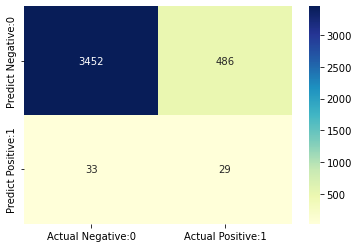

In [42]:
format_confusion_matrix(y_test, test_predictions_lgbm)

In [43]:
test_predictions_lgbm_proba = lgbm_final.predict_proba(X_test_data)

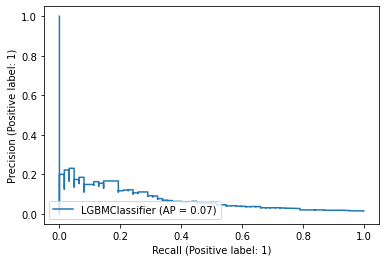

In [44]:
PrecisionRecallDisplay.from_estimator(lgbm_final, X_test_data, y_test)

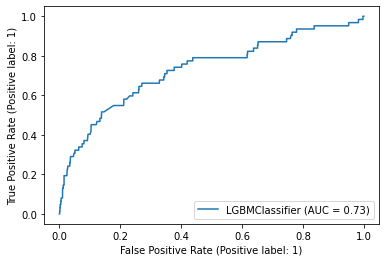

In [45]:
RocCurveDisplay.from_estimator(lgbm_final, X_test_data, y_test)

### Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

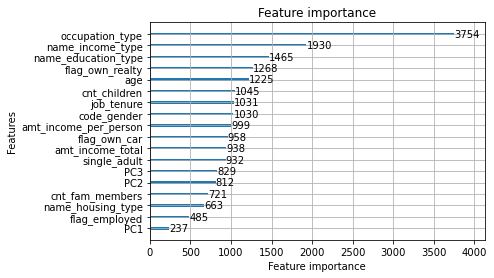

In [46]:
lgb.plot_importance(lgbm_final)

## Hyperparameter tuning for Random Forest

In [ ]:
criterion_choices = ["gini", "entropy"]
max_features_choices = ['sqrt', 'log2', None]

rf_reg_params = {
    'n_estimators':     hp.choice('n_estimators', np.arange(5, 3000, 1, dtype=int)),
    'max_depth':        hp.choice('max_depth', np.arange(2, 15, 1, dtype=int)),
    'min_samples_leaf': hp.uniform('min_samples_leaf',0.01, 0.3), 
    'criterion':        hp.choice("criterion", criterion_choices),
    'max_features':     hp.choice('max_features', max_features_choices)        
}

def obj_fun_rf(params):
    rf = RandomForestClassifier(class_weight='balanced', **params)
    rf.fit(X_train_data, y_train_data)
    train_cv_score = cross_val_score(rf, X_train_data, y_train_data, scoring="average_precision", cv = 5).mean()
    return -1.0 * train_cv_score

X_train_data = X_train_balanced_one_hot
y_train_data = y_train_balanced_one_hot
X_test_data = X_test_one_hot
y_test_data = y_test
        
trials_rf = Trials()
hyperopt_params_rf = fmin(
    fn = obj_fun_rf,                 # objective function
    space = rf_reg_params,           # parameter space
    algo = tpe.suggest,              # surrogate algorithm
    max_evals = 100,                 # no. of evaluations
    trials = trials_rf,              # trials object that keeps track of the sample results (optional)
    rstate = np.random.default_rng(seed)
)

In [48]:
hyperopt_params_rf

{'criterion': 0,
 'max_depth': 12,
 'max_features': 2,
 'min_samples_leaf': 0.010300420200765263,
 'n_estimators': 137}

In [49]:
hyperopt_params_rf = {'criterion': criterion_choices[hyperopt_params_rf['criterion']],
                       'max_depth': hyperopt_params_rf['max_depth'],
                       'max_features': max_features_choices[hyperopt_params_rf['max_features']],
                       'n_estimators': hyperopt_params_rf['n_estimators']}

In [50]:
hyperopt_params_rf

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': None,
 'n_estimators': 137}

In [51]:
# extract_and_plot_hyperopt_trials(trials_rf)

## Fitting model with selected params

In [52]:
rf_final = RandomForestClassifier(class_weight='balanced', **hyperopt_params_rf)
rf_final = rf_final.fit(X_train_data, y_train_data)

In [53]:
save_intermin_data_and_model(X_train_data, y_train_data, X_test_data, y_test_data, rf_final, 'rf')

### Model performance

In [54]:
train_cv_score_rf = cross_val_score(rf_final, X_train_data, y_train_data, scoring="average_precision", cv = 5, n_jobs=-1).mean()
print("train cv score: " + str(round(train_cv_score_rf, 2)))

train cv score: 0.99


In [55]:
test_predictions_rf = rf_final.predict(X_test_data)
summarise_metrices(y_test = y_test, y_hat = test_predictions_rf)

average_precision test: 0.06
f1 test: 0.19
precision test: 0.12
recall test: 0.39


<AxesSubplot:>

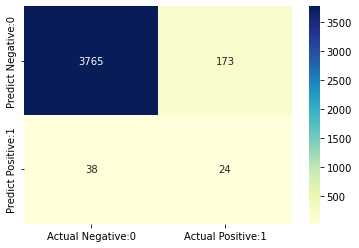

In [56]:
format_confusion_matrix(y_test, test_predictions_rf)

In [57]:
test_predictions_rf_proba = rf_final.predict_proba(X_test_data)

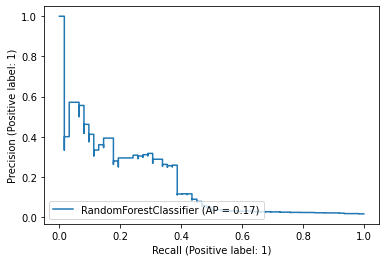

In [58]:
PrecisionRecallDisplay.from_estimator(rf_final, X_test_data, y_test)

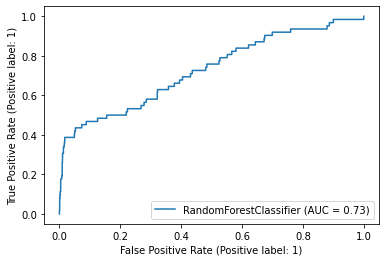

In [59]:
RocCurveDisplay.from_estimator(rf_final, X_test_data, y_test)

### Feature importance

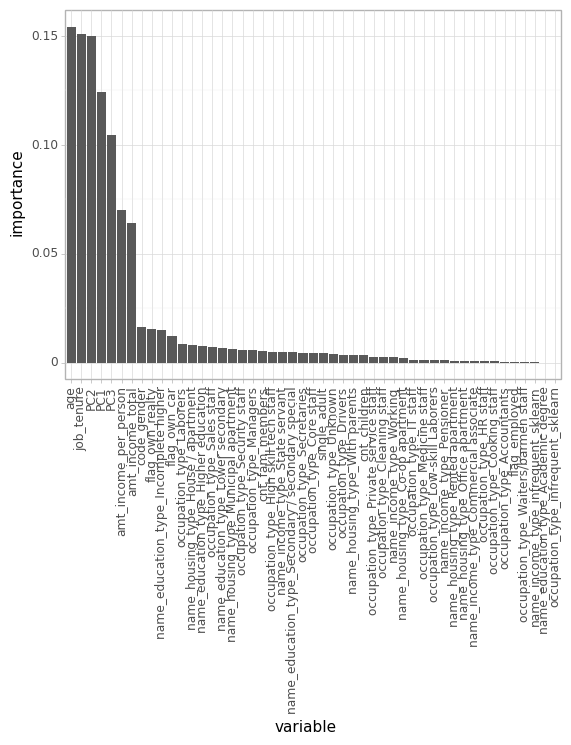

In [60]:
get_rf_feature_imp(rf_final)

# Final classification on test set

In [61]:
final_model = rf_final
test_predictions_final = test_predictions_rf
test_predictions_proba_final = test_predictions_rf_proba

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_test, test_predictions_final))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3938
           1       0.12      0.39      0.19        62

    accuracy                           0.95      4000
   macro avg       0.56      0.67      0.58      4000
weighted avg       0.98      0.95      0.96      4000



In [63]:
tbl_results_roc = pd.DataFrame()
tbl_results_roc['fpr'], tbl_results_roc['tpr'], tbl_results_roc['thresholds'] = roc_curve(y_test, test_predictions_proba_final[:,1])

In [64]:
tbl_results_pr = pd.DataFrame()

precision, recall, thresholds = precision_recall_curve(y_test[:], test_predictions_proba_final[:,1])
thresholds = np.append(thresholds, 1)

tbl_results_pr['precision'] = precision
tbl_results_pr['recall'] = recall
tbl_results_pr['thresholds'] = thresholds
tbl_results_pr['fscore'] = compute_f1(tbl_results_pr.precision, tbl_results_pr.recall)

## Results for default threshold = 0.5

In [65]:
print('Default threshold 0.5')
get_summary(tbl_results_pr, 0.5)

Default threshold 0.5


,precision,recall,thresholds,fscore
2718,0.121212,0.387097,0.499423,0.184615


In [66]:
get_summary(tbl_results_roc, 0.5)

,fpr,tpr,thresholds
82,0.042661,0.387097,0.506545


<AxesSubplot:>

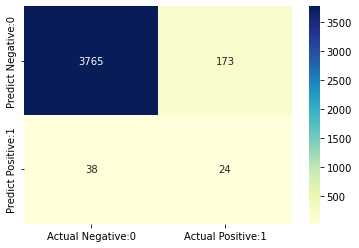

In [67]:
format_confusion_matrix(y_test, test_predictions_final)

## Results for best threshold

In [68]:
# locate the index of the largest f score
ix = np.argmax(tbl_results_pr.fscore)
best_threshold = tbl_results_pr.thresholds[ix]

In [69]:
print('Best Threshold: ' + str(best_threshold))
get_summary(tbl_results_pr, best_threshold)

Best Threshold: 0.8061630531639002


,precision,recall,thresholds,fscore
2824,0.316667,0.306452,0.806163,0.311475


In [70]:
get_summary(tbl_results_roc, best_threshold)

,fpr,tpr,thresholds
33,0.010411,0.306452,0.806163


<AxesSubplot:>

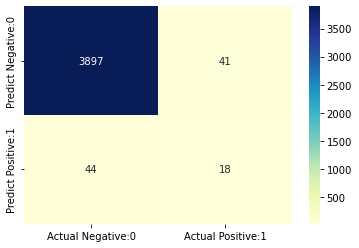

In [71]:
test_predictions_threshold_final = reclassify_by_treshold(test_predictions_proba_final, best_threshold)
format_confusion_matrix(y_test, test_predictions_threshold_final)